In [1]:
using Revise
using HypergraphDetectability
using DataFrames
using Clustering
using Statistics
using RCall
using Arpack

┌ Info: Precompiling HypergraphDetectability [2dbe4ab3-0c84-4f8d-86d2-f64d6d698dce]
└ @ Base loading.jl:1260
┌ Warning: Package HypergraphDetectability does not have StatsBase in its dependencies:
│ - If you have HypergraphDetectability checked out for development and have
│   added StatsBase as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with HypergraphDetectability
└ Loading StatsBase into HypergraphDetectability from project dependency, future warnings for HypergraphDetectability are suppressed.


In [2]:
n  = 100
c₂ = 5
c₃ = 5
z  = 1 .+ (1:n .> n/2);
p₂ = 0.7
p₃ = 0.7
H = detectabilityData(n, c₂, c₃, p₂, p₃);

In [3]:
B = reducedNonBacktrackingMatrix(H);

In [4]:
E = Arpack.eigs(B; nev = 400);

┌ Warning: Adjusting nev from 400 to 398
└ @ Arpack /home/phil/.julia/packages/Arpack/o35I5/src/Arpack.jl:82


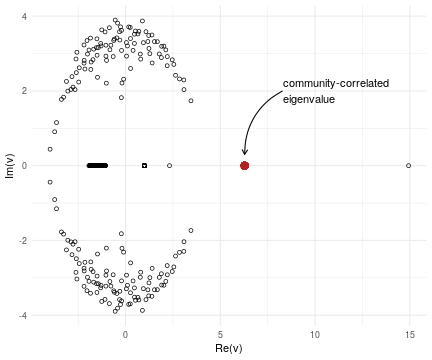

RObject{VecSxp}


In [69]:
R"""
library(tidyverse)
df <- tibble(R = $(real.(E[1])), C = $(imag.(E[1])))

p <- df %>% 
    ggplot() + 
    aes(x = R, y = C) + 
    geom_point(pch = 21) + 
    theme_minimal() +
    geom_point(x = $(real(E[1][2])), y = $(imag(E[1][2])), color = "firebrick", size = 3) + 
    xlab("Re(v)") + 
    ylab("Im(v)") + 
    annotate(
        geom = "curve", xend = $(real(E[1][2])), yend = 0.3, x = $(real(E[1][2])) + 2, y = 2, 
        curvature = .3, arrow = arrow(length = unit(2, "mm"))
        ) +
    annotate(geom = "text", x = $(real(E[1][2])) + 2, y = 2, label = "community-correlated\neigenvalue", hjust = "left")
p    
"""

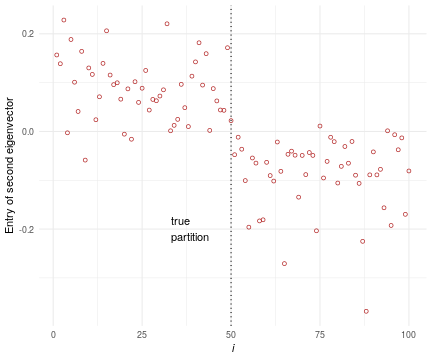

RObject{VecSxp}


In [73]:
v = E[2][:,2][1:n] + E[2][:,2][(n+1):2n]

R"""

df <- tibble(v = $(real.(v))) %>% 
    mutate(i = row_number())

q <- df %>% 
    ggplot() + 
    aes(x = i, y = v) +
    geom_point(color = "firebrick", pch = 21) + 
    theme_minimal() + 
    geom_vline(xintercept = 50, linetype = "dotted") + 
    xlab(expression(italic(i))) + 
    ylab("Entry of second eigenvector") + 
    annotate(geom = "text", x = 33, y = -.2, label = "true\npartition", hjust = "left")

q
"""


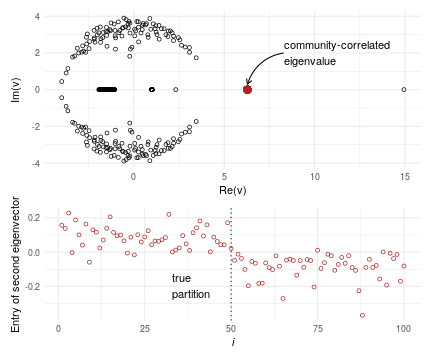

RObject{VecSxp}


In [74]:
R"""
library(patchwork)

s <- p / q + plot_layout(widths = c(1, 1), heights = c(1.4, 1))

ggsave("fig/eigen-illustration.png",  s, width = 5, height = 4.5)

s
"""

## Heatmap

In [80]:
function experiment(P₂, P₃, n, c₂, c₃, z)
    P2, P3,  MI, EV = zeros(0), zeros(0), zeros(0), zeros(0)
    for p₂ ∈ P₂, p₃ ∈ P₃
        H = detectabilityData(n, c₂, c₃, p₂, p₃);
        B = reducedNonBacktrackingMatrix(H)
        try 
            E = Arpack.eigs(B; nev = 2, ritzvec = true)
            
            for ev ∈ [2]
                v = E[2][:,ev]
                u = E[2][:,2][1:n] + E[2][:,2][(n+1):2n]
                if !(mean(abs.(imag.(u))) ≈ 0)
                    mi = 0.0
                    append!(P2, p₂)
                    append!(P3, p₃)
                    append!(MI, mi)
                    append!(EV, ev)
                else
                    clusters = 1 .+ (real.(u) .> 0)
                    mi = mutualinfo(clusters, z)
                    append!(P2, p₂)
                    append!(P3, p₃)
                    append!(MI, mi)
                    append!(EV, ev)
                end
            end
        catch e
            nothing
        end
    end
    DF = DataFrame(
        P_2 = P2, 
        P_3 = P3, 
        MI = MI, 
        EV = EV
    )
    return DF
end

experiment (generic function with 1 method)

In [69]:
# n_reps = 20
# DF = DataFrame()

# for rep ∈ 1:n_reps
#    println("round $(rep)")
#    df = experiment(0:0.01:1, 0:0.01:1, n, c₂, c₃, z);
#    append!(DF, df)
# end

In [ ]:
R"""
# library(tidyverse)
# df <- tibble($(DF))
# df
# df %>% write_csv("throughput/vanilla-heatmap.csv")
""";

┌ Warning: RCall.jl: Parsed with column specification:
│ cols(
│   P_2 = col_double(),
│   P_3 = col_double(),
│   MI = col_double(),
│   EV = col_double()
│ )
└ @ RCall /home/phil/.julia/packages/RCall/Qzssx/src/io.jl:160
┌ Warning: RCall.jl: `summarise()` regrouping output by 'P_2', 'P_3' (override with `.groups` argument)
└ @ RCall /home/phil/.julia/packages/RCall/Qzssx/src/io.jl:160


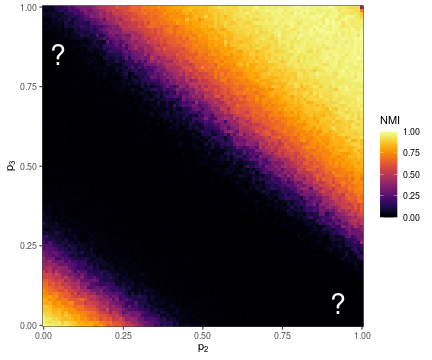

RObject{VecSxp}


In [81]:
R"""
library(tidyverse)
library(viridis)

df <- read_csv("throughput/vanilla-heatmap.csv")

df <- df %>%
    group_by(P_2, P_3, EV) %>% 
    summarise(MI = mean(MI, na.rm = T))

p <- df %>% 
    ggplot() + 
    aes(x = P_2, y = P_3, fill = MI) + 
    geom_tile() + 
    theme_bw() + 
    scale_fill_viridis(option = "inferno", limits = c(0, 1)) + 
    scale_x_continuous(expand = c(0,0)) + 
    scale_y_continuous(expand = c(0,0)) + 
    xlab(expression(p[2])) + 
    ylab(expression(p[3])) + 
    theme(panel.grid = element_blank(), 
    panel.spacing = unit(2, "lines"),
    strip.background = element_blank(),
    panel.spacing.x = unit(8, "mm"),
    strip.text = element_text(size = 10)) + 
    coord_fixed() + 
    annotate(geom = "text", x = 0.9, y = 0.07, label = "?", hjust = "left", color = "white", size = 10) + 
    annotate(geom = "text", x = 0.02, y = 0.85, label = "?", hjust = "left", color = "white", size = 10) + 
    guides(fill = guide_colorbar(title = "NMI"))
    

ggsave("fig/vanilla-heatmap.png", p,  width = 5, height = 4)
p
"""